# Final Project: House Price Prediction 

## Corpus Christi Team 

## Step 5 (Machine Learning Model for House Predictions)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import requests
import urllib.request
import seaborn as sns

from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.datasets import make_blobs
from sklearn import metrics
from xgboost import plot_importance

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


from shapash.explainer.smart_explainer import SmartExplainer

import re
import os
import glob
from datetime import datetime as dt
import warnings
from time import sleep
from tqdm import tqdm

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Read the CSV and Perform Basic Data Cleaning 

In [2]:
# https://github.com/Hecgithub/House_Price_Prediction/blob/03_Data_Gathering_and_Cleaning/03_Code_and_Data/03_Data_Cleaning/data/05_Raw_from_DB_htx_joined_data_house_crime.csv

columns = [
    "price", "bedrooms", "bathrooms", "constructedarea", "zipcode", "yearbuilt", "lotareasqft", 
    "avgschoolrating", "avgschooldist", "crimepercentage" 
]

target = ["price"]

In [3]:
# reading in the data set from the github 
url = 'https://raw.githubusercontent.com/Hecgithub/House_Price_Prediction/main/03_Code_and_Data/05_ML_Model/data/05_ML_from_DB_htx_joined_data_house_crime.csv'

urllib.request.urlretrieve(url, '05_ML_from_DB_htx_joined_data_house_crime.csv')

('05_ML_from_DB_htx_joined_data_house_crime.csv',
 <http.client.HTTPMessage at 0x2d860947d08>)

In [4]:
# There are 25 columns and 4499 rows 
df = pd.read_csv('05_ML_from_DB_htx_joined_data_house_crime.csv')
print(df.shape)

(4500, 10)


In [5]:
# Peek at the dateset
df.head()

,price,bedrooms,bathrooms,constructedarea,zipcode,yearbuilt,lotareasqft,avgschoolrating,avgschooldist,crimepercentage
0,276000,3,2,3612.0,77489,1971,8764.272,3.666667,0.966667,0.336866
1,220000,3,2,1270.0,77489,1972,7884.360,3.666667,0.866667,0.336866
2,230000,4,2,1765.0,77489,1974,7148.196,3.666667,0.633333,0.336866
3,225000,3,2,1444.0,77489,1978,7731.900,3.666667,0.833333,0.336866
4,246500,3,2,1738.0,77489,1978,8062.956,3.666667,0.633333,0.336866


In [6]:
# Checking the features of the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            4500 non-null   int64  
 1   bedrooms         4500 non-null   int64  
 2   bathrooms        4500 non-null   int64  
 3   constructedarea  4500 non-null   float64
 4   zipcode          4500 non-null   int64  
 5   yearbuilt        4500 non-null   int64  
 6   lotareasqft      4500 non-null   float64
 7   avgschoolrating  4500 non-null   float64
 8   avgschooldist    4500 non-null   float64
 9   crimepercentage  4500 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 351.7 KB


In [7]:
# Reaplce all null values by the average of the column values
df = df.fillna(df.mean())

In [8]:
# Find columns with missing values and their percent missing
df.isnull().sum()                                                     
miss_val = df.isnull().sum().sort_values(ascending=False)
miss_val = pd.DataFrame(data=df.isnull().sum().sort_values(ascending=False), columns=['MissvalCount'])
miss_val


,MissvalCount
price,0
bedrooms,0
bathrooms,0
constructedarea,0
zipcode,0
yearbuilt,0
lotareasqft,0
avgschoolrating,0
avgschooldist,0
crimepercentage,0


In [9]:
# drop rows with any missing values
df.dropna(inplace=True)

In [10]:
# Check the dimension of the dataset
df.shape

(4500, 10)

Data set is has 10 features and 4500 observations 

# Explore Data

In [11]:
# Get statistics
df.describe()

,price,bedrooms,bathrooms,constructedarea,zipcode,yearbuilt,lotareasqft,avgschoolrating,avgschooldist,crimepercentage
count,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
mean,401480.002667,3.393556,2.830667,2158.662015,77070.912667,1993.300222,7776.873718,108.415534,105.570933,1.027040
std,157007.688575,0.724881,0.887162,711.170309,81.504576,28.878517,22153.124331,304.181863,305.144595,0.699221
min,200000.000000,0.000000,0.000000,0.000000,77003.000000,1888.000000,0.000000,2.000000,0.166667,0.000435
25%,280000.000000,3.000000,2.000000,1680.750000,77022.000000,1970.000000,4225.757000,3.333333,0.933333,0.356886
50%,364000.000000,3.000000,3.000000,2020.000000,77057.000000,2003.000000,6993.558000,4.333333,1.333333,1.130285
75%,469990.000000,4.000000,3.000000,2528.250000,77084.000000,2022.000000,8160.000000,6.000000,1.966667,1.481514
max,900000.000000,10.000000,7.000000,6793.000000,77598.000000,2023.000000,980100.000000,999.000000,999.000000,3.719017


<AxesSubplot:>

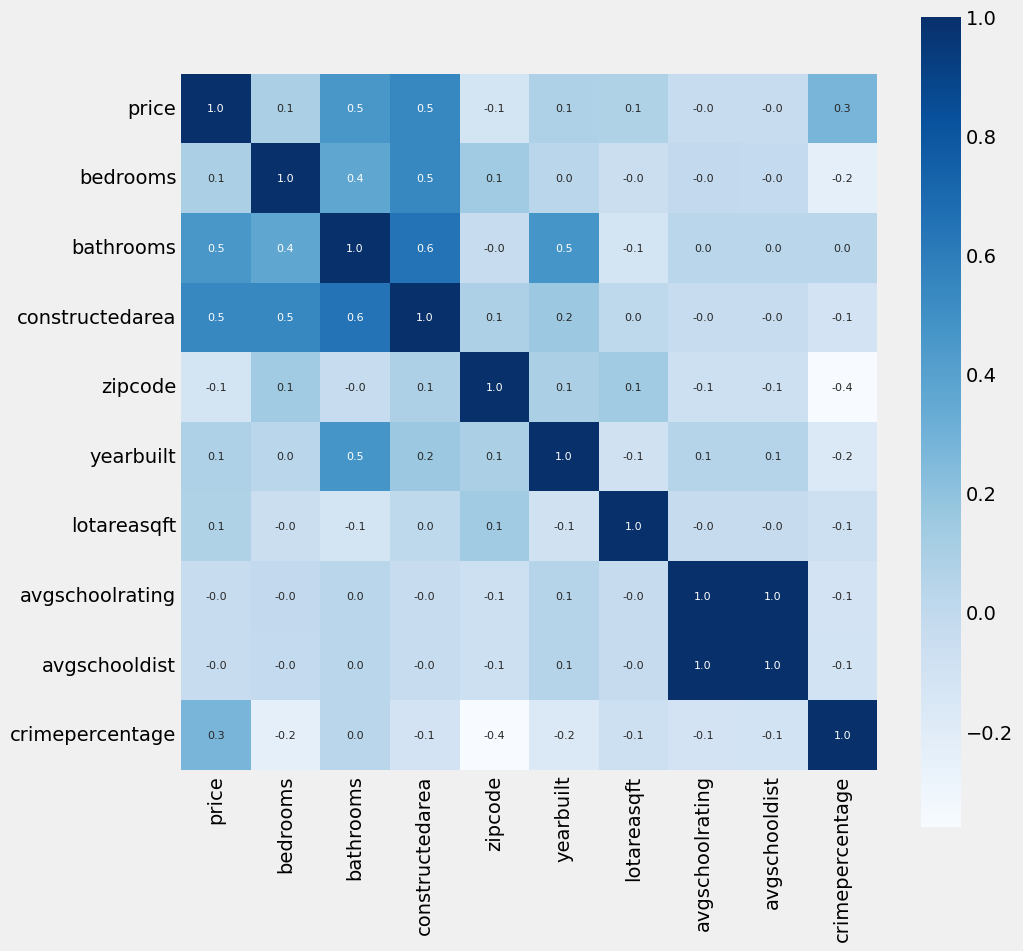

In [12]:
# Heat map
# A heat map shows the correlation between the input data columns
# There are 2 types of correlation:
# Positive: As the magnitude of a feature increases, the magnitude of a correlated feature increases
# Negative: As the magnitude of a feature increases, the magnitude of a correlated feature decreases
correlation = df.corr()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,10))
sns.heatmap(correlation, cbar=True, square=True, fmt='.1f', annot=True, annot_kws={'size':8}, cmap='Blues')

<AxesSubplot:xlabel='price', ylabel='Density'>

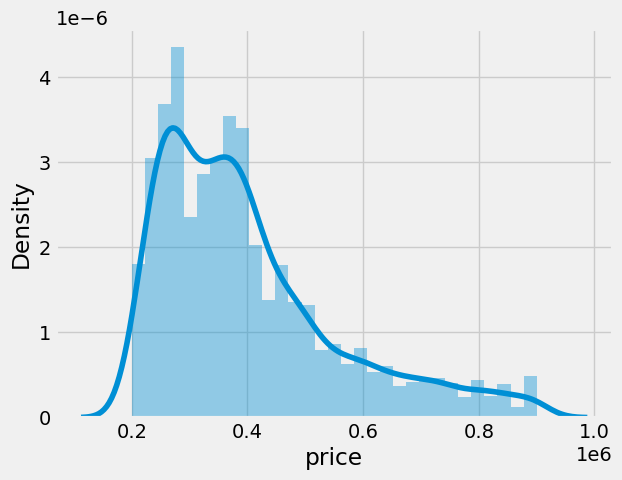

In [13]:
# Check distribution of target variable which is Price
sns.distplot(df.price)

The Price distribution is slightly skewed to the right. 

In [14]:
# Review the skewness of each feature
df.skew().sort_values(ascending=False)

lotareasqft        37.630525
zipcode             3.028691
avgschooldist       2.587556
avgschoolrating     2.587277
price               1.213271
constructedarea     1.194945
bedrooms            0.722523
crimepercentage     0.234891
bathrooms           0.216770
yearbuilt          -0.613141
dtype: float64

Values that are closer to zero are less skewed. 

# Train- Test Split dataset


In [15]:
# Get the features and the target column 
# X = Features, y = target
X = df.drop('price', axis=1)
y = df[["price"]]

In [16]:
# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
print(X.shape, X_train.shape, X_test.shape)

(4500, 9) (3600, 9) (900, 9)


Spliting the data set, will use random sampling with 80/20 train-test split. 

# Modeling

## Linear Regression 

In [17]:
lr = LinearRegression()
# fit optimal linear regression line on training data, this performs gradient descent under the hood
lr.fit(X_train, y_train)

LinearRegression()

In [18]:
# given our model and our fit, predict y_values using X_test set
yr_hat = lr.predict(X_test)

In [19]:
# evaluate the algorithm with a test set 
lr_score = lr.score(X_test, y_test)  # train test 
print("Accuracy: ", lr_score)

Accuracy:  0.41959919625790887


In [20]:
# cross validation to find 'validate' score across multiple samples, automatically does Kfold stratifying
lr_cv = cross_val_score(lr, X, y, cv = 5, scoring= 'r2')
print("Cross-validation results: ", lr_cv)
print("R2: ", lr_cv.mean())

Cross-validation results:  [0.02657333 0.20421898 0.51704361 0.53811686 0.45244501]
R2:  0.3476795599485184


## Random Forest

In [21]:
#rfr = RandomForestRegressor(n_estimators = 100, max_depth = 5, min_samples_leaf= 5, max_features = 'sqrt')  # using GridSearch
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train) # gets the parameters for the rfr model
rfr_cv = cross_val_score(rfr,X, y, cv = 5, scoring = 'r2')
print("R2: ", rfr_cv.mean())

R2:  0.6640095787895918


In [22]:
# Random forest determined feature importances
rfr.feature_importances_

array([0.01332883, 0.01908582, 0.41255206, 0.10769725, 0.07382254,
       0.09228052, 0.06384937, 0.04565408, 0.17172952])

## XGBRegressor

In [23]:
# Load the model (XGBoost Regressor)
model = XGBRegressor()

# Train the model with the training data
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [24]:
y_pred = model.predict(X_test)

# Calculate the R squared error
error_r2 = metrics.r2_score(y_test, y_pred)

# Calculate the mean absolute error
error_ma = metrics.mean_absolute_error(y_test, y_pred)

print(f'R squared error: {error_r2} (should be close to 1)')

R squared error: 0.7653435055645262 (should be close to 1)


## Plotting Feature Importance 

In [25]:
# Display the actual price vs the predicted price
y_test_df = y_test.reset_index(drop=True)
y_test_df = y_test_df.rename(columns = {'Price':'Actual_Price'})

y_pred_df = pd.DataFrame(y_pred, columns = ['Predicted_Price'])
y_pred_df = y_pred_df['Predicted_Price'].apply(np.ceil).astype('int')

# Display the actual and the predicted prices side by side
df_prices = pd.concat([y_test_df, y_pred_df], axis=1)
df_prices

,price,Predicted_Price
0,325000,380946
1,899900,810725
2,235000,264677
3,489000,447649
4,279000,434513
...,...,...
895,579900,621828
896,374900,336019
897,395000,500603
898,219900,264460


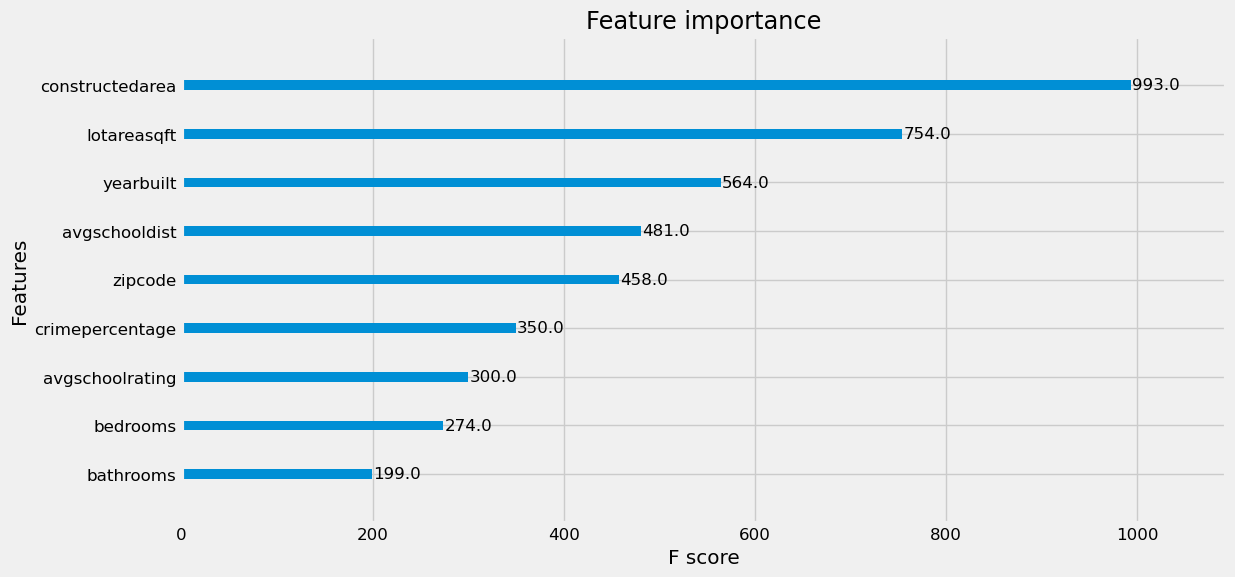

In [26]:
# Plot the features importance
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(12,6))
plot_importance(model, ax=ax)
plt.show();

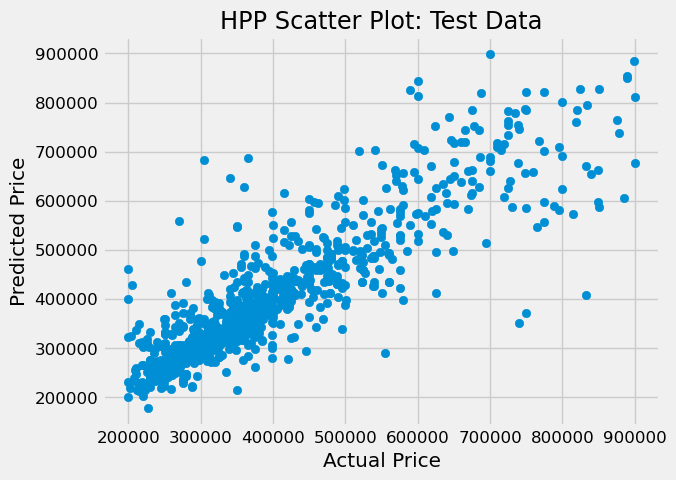

In [27]:
# Scatter Plot using test data
plt.scatter(y_test_df, y_pred_df)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('HPP Scatter Plot: Test Data')
plt.show()

## Understanding the model with Shapash

### If not installed, run the following command in your conda environment
!pip install shapash

In [28]:
# Initialize shapash with the ML model
xpl = SmartExplainer(model)

In [29]:
# Condition X_test and y_pred for Shapash
# Display the actual price vs the predicted price
temp = X_test.reset_index(drop=True)
sp_X_test = temp.rename(columns = {'Price':'Price'})
del(temp)

temp = pd.DataFrame(y_pred, columns = ['Price'])
sp_y_pred = temp['Price'].apply(np.ceil).astype('int')
del(temp)

temp = y_test.reset_index(drop=True)
sp_y_target = temp.rename(columns = {'Price':'Price'})
del(temp)

In [30]:
# Compile shapash
xpl.compile(x=sp_X_test, y_pred=sp_y_pred, y_target=sp_y_target)

In [31]:
app = xpl.run_app(title_story='House_Price_Prediction')

Dash is running on http://0.0.0.0:8050/



INFO:root:Your Shapash application run on http://LAPTOP-AIQ1UT08:8050/
INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8050/

INFO:root:Use the method .kill() to down your app.


In [32]:
# Plot a summary with the contribution of the features
summary_df = xpl.to_pandas(max_contrib=14) #Number of max features to show in summary
summary_df.head()

 * Serving Flask app 'shapash.webapp.smart_app' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


,Price,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3,feature_4,value_4,contribution_4,feature_5,value_5,contribution_5,feature_6,value_6,contribution_6,feature_7,value_7,contribution_7,feature_8,value_8,contribution_8,feature_9,value_9,contribution_9
0,380946,lotareasqft,11251.548,65200.878906,zipcode,77009.0,56311.332031,avgschoolrating,3.0,-55382.527344,constructedarea,780.0,-54675.992188,bedrooms,5.0,-44585.65625,yearbuilt,1946.0,12139.217773,bathrooms,2.0,-7371.883301,avgschooldist,0.433333,5139.931152,crimepercentage,1.501534,3378.085693
1,810725,constructedarea,3000.0,163786.53125,zipcode,77009.0,86196.867188,crimepercentage,1.501534,64896.984375,yearbuilt,2023.0,52989.730469,avgschooldist,0.733333,17642.212891,avgschoolrating,5.333333,13817.404297,bathrooms,4.0,6573.938965,lotareasqft,5000.0,3978.090576,bedrooms,4.0,50.575874
2,264677,crimepercentage,0.382565,-51804.242188,constructedarea,1869.0,-37611.96875,yearbuilt,1983.0,-35529.355469,lotareasqft,6298.776,-13292.53418,avgschoolrating,5.333333,7113.09668,zipcode,77041.0,-5961.984375,bathrooms,3.0,-3359.331543,bedrooms,3.0,2891.871338,avgschooldist,1.533333,1439.111328
3,447649,zipcode,77004.0,86444.28125,avgschoolrating,3.0,-61412.992188,yearbuilt,2021.0,22766.484375,crimepercentage,2.457729,15946.169922,avgschooldist,1.066667,-7781.561523,constructedarea,2348.0,-4682.770996,lotareasqft,7775.70134,-3221.677246,bedrooms,4.0,-2449.048096,bathrooms,5.0,1247.751343
4,434513,zipcode,77089.0,-83594.671875,constructedarea,2639.0,75955.679688,crimepercentage,0.858703,21897.056641,avgschoolrating,5.666667,18468.615234,avgschooldist,1.0,9926.319336,yearbuilt,1965.0,-9455.258789,bedrooms,4.0,-3662.293213,lotareasqft,7775.46,2286.957031,bathrooms,2.0,1897.930176


In [33]:
# Kill the dashboard (Run when done)
#app.kill

INFO:werkzeug: * Running on http://192.168.1.227:8050/ (Press CTRL+C to quit)
INFO:werkzeug:192.168.1.227 - - [10/Jan/2023 21:11:43] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:192.168.1.227 - - [10/Jan/2023 21:11:43] "POST /_dash-update-component HTTP/1.1" 204 -
INFO:werkzeug:192.168.1.227 - - [10/Jan/2023 21:11:43] "POST /_dash-update-component HTTP/1.1" 204 -
INFO:werkzeug:192.168.1.227 - - [10/Jan/2023 21:11:43] "POST /_dash-update-component HTTP/1.1" 204 -
INFO:werkzeug:192.168.1.227 - - [10/Jan/2023 21:11:43] "POST /_dash-update-component HTTP/1.1" 204 -
INFO:werkzeug:192.168.1.227 - - [10/Jan/2023 21:11:43] "POST /_dash-update-component HTTP/1.1" 204 -
INFO:werkzeug:192.168.1.227 - - [10/Jan/2023 21:11:46] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:192.168.1.227 - - [10/Jan/2023 21:11:46] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:192.168.1.227 - - [10/Jan/2023 21:11:46] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug